# Interpreting Linear Regression Coefficients: A Baseball Example

A virtue of linear regression models is that they're easy to understand.  The coefficients usually have a very natural interpretation.  Here I'll present what I think is a fun example where the naive way of interpreting these coefficients breaks down.

Let me begin with a question, which I hope you'll answer without thinking too hard about it.

Suppose we take a dataset of MLB batting statistics since from 1871-2015 and run a linear regression to predict a batter's single season RBI (Runs Batted In) using their HR, 3B, 2B, and 1B from the same season.  What, approximately, do you think each of the coefficients will be?  Write down your answer before reading further.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [31]:
batting = pd.read_csv('Data/Baseball/batting.csv')

In [32]:
batting.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,25,118.0,30.0,32.0,6.0,...,13.0,8.0,1.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN
2,allisar01,1871,1,CL1,NaN,29,137.0,28.0,40.0,4.0,...,19.0,3.0,1.0,2.0,5.0,NaN,NaN,NaN,NaN,NaN
3,allisdo01,1871,1,WS3,NaN,27,133.0,28.0,44.0,10.0,...,27.0,1.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN
4,ansonca01,1871,1,RC1,NaN,25,120.0,29.0,39.0,11.0,...,16.0,6.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN


In [33]:
#Singles are not directly stored in the dataframe, so we make a 1B column ourselves.
batting['1B'] = batting['H'] - batting['2B'] - batting['3B'] - batting['HR']

In [34]:
batting.dropna(inplace=True)
X= np.array(batting[['HR', '3B', '2B', '1B']])
y= np.array(batting['RBI'])
reg = LinearRegression().fit(X,y)
reg.coef_, reg.intercept_, reg.score(X,y)

(array([ 1.92621606, -0.06588546,  0.5500652 ,  0.24537098]),
 0.19762859830731827,
 0.9661682587964813)

So the best linear model for RBI using HR, 3B, 2B, 1B as predictors is:

### RBI ~ 1.93 \* HR - 0.07 \* 3B + 0.55 \* 2B + 0.25 \* 1B + 0.20

That's right -- the coefficient for triples (3B) is negative!

And what's more, the fit is quite good, as the R^2 = 0.97 and the below plot of RBI vs. Predicted RBI show.

In [37]:
batting['pred_RBI'] = reg.predict(X)

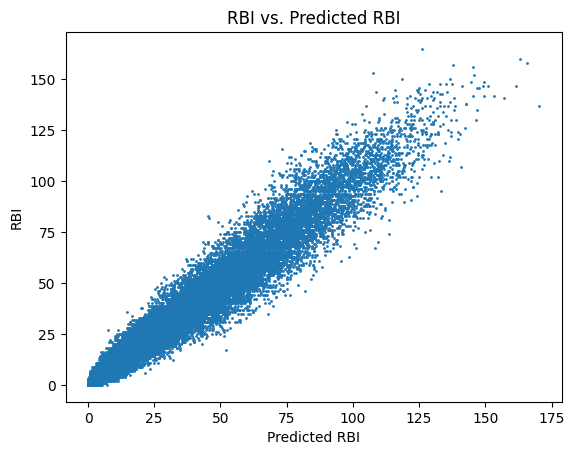

In [48]:
plt.scatter(batting['pred_RBI'], batting['RBI'], s=1)
plt.xlabel('Predicted RBI')
plt.ylabel('RBI')
plt.title('RBI vs. Predicted RBI')
plt.show()

So what's going on here?  I think a naive interpretation of the coefficients in this situation would be that they represent the average number of runs scored on the play when a batter gets the corresponding hit.  E.g. if you think there is an average of 0.93 men on base when a home run is hit, you would guess 1.93 as the coefficient of HR (the batter also scores on a home run!). I suspect this reasoning is not too far off in the cases of HR, 2B, and 1B. (It would be interesting to check exactly how many runs are scored on each of these hits on average.)  But clearly this story doesn't work for the coefficient of 3B.

The problem here is that this interpretation makes the assumption that a batter's HR, 3B, 2B, and 1B are independent of any confounding variables, whereas there seem to be a couple of significant confounders in the case of triples.  A player who hits a lot of triples is, on average, a fast runner and the kind of player who might hit 1st, 8th, or 9th in the lineup -- so they have fewer men on base when they come to bat, meaning the hits they get are less RBI-rich on average.  Secondly, a speedy high-3B player is also more likely to be valued for their versatility, fielding, and ability to steal bases.  None of these skills is related in a direct way with getting hits, and so I suspect they mostly negatively correlate with hits. (If a position player had **none** of these skills, they wouldn't be in MLB!)

In summary, if a player gets a lot of triples, on the one hand, they get a certain number of RBI directly from those hits. On the other hand, they are possibly more likely to be the type of player who contributes in ways other than getting hits; moreover, they are less likely to bat in the middle of the order, so the hits they do get are expected to be less RBI-rich. Based on both the data and my baseball knowledge, I don't think there are similar confounders for HR, 2B, or 1B.